# Random Forest PyTorch with MNIST 1000
- **Task**: Classification
- **Data**: MNIST 1000 Dataset
- **Model**: Random Forest
- **Criterion**: Entropy

In [1]:
!pip install -q watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.8 MB/s eta 0:00:00


In [2]:
%load_ext watermark
%watermark -a 'Nguyen Van Sy Thinh' -v -p torch

Author: Nguyen Van Sy Thinh

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

torch: 2.3.0+cu121



## 1. Import Library

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import time
from math import log, sqrt
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Data

### 2.1. MNIST Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    nn.Flatten()
])

# Loading training data
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)
# Loading test data
test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 51407943.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1860620.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13606540.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1561006.95it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### 2.2. Data Information

In [5]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 60000
Number of testing samples: 10000


In [6]:
print(f"Datatype of the 1st training sample: {train_dataset[0][0].type()}")
print(f"Size of the 1st training sample: {train_dataset[0][0].size()}")

Datatype of the 1st training sample: torch.FloatTensor
Size of the 1st training sample: torch.Size([1, 784])


### 2.3. Data Visualization

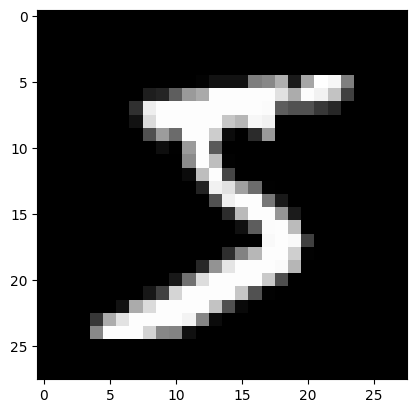

In [7]:
img_5 = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(img_5, cmap='gray')
plt.show()

### 2.4. Load Dataset into TorchTensor

In [8]:
x_train = torch.stack([train_dataset[i][0].squeeze() for i in range(len(train_dataset))]).to(device)
y_train = torch.tensor([train_dataset[i][1] for i in range(len(train_dataset))], dtype=torch.int64).to(device)
x_test = torch.stack([test_dataset[i][0].squeeze() for i in range(len(test_dataset))]).to(device)
y_test = torch.tensor([test_dataset[i][1] for i in range(len(test_dataset))], dtype=torch.int64).to(device)

In [9]:
print(f"{x_train.shape = }")
print(f"{x_train.dtype = }")
print(f"{y_train.shape = }")
print(f"{y_train.dtype = }")

x_train.shape = torch.Size([60000, 784])
x_train.dtype = torch.float32
y_train.shape = torch.Size([60000])
y_train.dtype = torch.int64


## 3. Model

### 3.1. Utils

In [10]:
from math import log, sqrt
import torch
import random


def unique_counts(labels):
    """
    Unique count function used to count labels.
    """
    results = {}
    for label in labels:
        value = label.item()
        if value not in results.keys():
            results[value] = 0
        results[value] += 1
    return results


def divide_set(vectors, labels, column, value):
    """
    Divide the sets into two different sets along a specific dimension and value.
    """
    set_1 = [(vector, label) for vector, label in zip(vectors, labels) if split_function(vector, column, value)]
    set_2 = [(vector, label) for vector, label in zip(vectors, labels) if not split_function(vector, column, value)]

    vectors_set_1 = [element[0] for element in set_1]
    vectors_set_2 = [element[0] for element in set_2]
    label_set_1 = [element[1] for element in set_1]
    label_set_2 = [element[1] for element in set_2]

    return vectors_set_1, label_set_1, vectors_set_2, label_set_2


def split_function(vector, column, value):
    """
    Split function
    """
    return vector[column] >= value


def log2(x):
    """
    Log2 function
    """
    return log(x) / log(2)


def sample_vectors(vectors, labels, nb_samples):
    """
    Sample vectors and labels uniformly.
    """
    sampled_indices = torch.LongTensor(random.sample(range(len(vectors)), nb_samples))
    sampled_vectors = torch.index_select(vectors,0, sampled_indices)
    sampled_labels = torch.index_select(labels,0, sampled_indices)

    return sampled_vectors, sampled_labels


def sample_dimensions(vectors):
    """
    Sample vectors along dimension uniformly.
    """
    sample_dimension = torch.LongTensor(random.sample(range(len(vectors[0])), int(sqrt(len(vectors[0])))))

    return sample_dimension


def entropy(labels):
    """
    Entropy function.
    """
    results = unique_counts(labels)
    ent = 0.0
    for r in results.keys():
        p = float(results[r]) / len(labels)
        ent = ent - p * log2(p)
    return ent


def variance(values):
    """
    Variance function.
    """
    mean_value = mean(values)
    var = 0.0
    for value in values:
        var = var + torch.sum(torch.sqrt(torch.pow(value-mean_value,2))).item()/len(values)
    return var


def mean(values):
    """
    Mean function.
    """
    m = 0.0
    for value in values:
        m = m + value/len(values)
    return m

### 3.2. Decision Node

In [11]:
class DecisionNode:
    """
    Node decision object which is used to build a binary tree. It groups the splitting function and either the different
    nodes below (left and right) or a result value to return.

    Args:
        col (:class:`int`): The dimension along which the splitting is performed.
        value (:class:`float`): The value which splits the space into two different spaces for the dimension specified
            above.
        results (:class:`dict` or :class:`torch.FloatTensor`): The results value to return if no splitting function is
            given. It can be either a dictionary where the keys correspond to the labels returned and the different
            count associated, either a value tensor to return.
        tb (:class:`DecisionNode`): The node to call recursively in the case the splitting function returns true.
        fb (:class:`DecisionNode`): The node to call recursively in the case the splitting function returns false.
    """
    def __init__(self, col=-1, value=None, results=None, tb=None, fb=None):
        self.col = col
        self.value = value
        self.results = results
        self.tb = tb
        self.fb = fb

### 3.3. Decision Tree Classifier

In [12]:
class DecisionTreeClassifier(torch.nn.Module):
    """
    Torch decision tree object used to solve classification problem. This object implements the fitting and prediction
    function which can be used with torch tensors. The binary tree is based on
    :class:`decision_node.DecisionNode` which are built during the :func:`fit` and called recursively during the
    :func:`predict`.

    Args:
        max_depth (:class:`int`): The maximum depth which corresponds to the maximum successive number of
            :class:`decision_node.DecisionNode`.

    """
    def __init__(self, max_depth=-1):
        self._root_node = None
        self.max_depth = max_depth

    def fit(self, vectors, labels, criterion=None):
        """
        Function which must be used after the initialisation to fit the binary tree and build the successive
        :class:`decision_node.DecisionNode` to solve a specific classification problem.

        Args:
            vectors (:class:`torch.FloatTensor`): Vectors tensor used to fit the decision tree. It represents the data
                and must correspond to the following shape [num_vectors, num_dimensions].
            labels (:class:`torch.LongTensor`): Labels tensor used to fit the decision tree. It represents the labels
                associated to each vectors and must correspond to the following shape [num_vectors].
            criterion (:class:`function`): Optional function used to optimize the splitting for each
                :class:`decision_node.DecisionNode`. If none given, the entropy function is used.
        """
        if len(vectors) < 1:
            raise ValueError("Not enough samples in the given dataset")
        if len(vectors) != len(labels):
            raise ValueError("Labels and data vectors must have the same number of elements")
        if not criterion:
            criterion = entropy

        self._root_node = self._build_tree(vectors, labels, criterion, self.max_depth)

    def _build_tree(self, vectors, labels, func, depth):
        """
        Private recursive function used to build the tree.
        """
        if len(vectors) == 0:
            return DecisionNode()
        if depth == 0:
            return DecisionNode(results=unique_counts(labels))

        current_score = func(labels)
        best_gain = 0.0
        best_criteria = None
        best_sets = None
        column_count = len(vectors[0])

        for col in range(0, column_count):
            column_values = {}
            for vector in vectors:
                column_values[vector[col]] = 1
            for value in column_values.keys():
                vectors_set_1, label_set_1, vectors_set_2, label_set_2 = divide_set(vectors, labels, col, value)

                p = float(len(vectors_set_1)) / len(vectors)
                gain = current_score - p * func(label_set_1) - (1 - p) * func(label_set_2)
                if gain > best_gain and len(vectors_set_1) > 0 and len(vectors_set_2) > 0:
                    best_gain = gain
                    best_criteria = (col, value)
                    best_sets = ((vectors_set_1,label_set_1), (vectors_set_2,label_set_2))

        if best_gain > 0:
            true_branch = self._build_tree(best_sets[0][0], best_sets[0][1], func, depth - 1)
            false_branch = self._build_tree(best_sets[1][0], best_sets[1][1], func, depth - 1)
            return DecisionNode(col=best_criteria[0],
                                value=best_criteria[1],
                                tb=true_branch, fb=false_branch)
        else:
            return DecisionNode(results=unique_counts(labels))

    def predict(self, vector):
        """
        Function which must be used after the the fitting of the binary tree. It calls recursively the different
        :class:`decision_node.DecisionNode` to classify the vector.

        Args:
            vector(:class:`torch.FloatTensor`): Vectors tensor which must be classified. It represents the data
                and must correspond to the following shape (num_dimensions).

        Returns:
            :class:`torch.LongTensor`: Tensor which corresponds to the label predicted by the binary tree.

        """
        return self._classify(vector, self._root_node)

    def _classify(self, vector, node):
        """
        Private recursive function used to classify with the tree.
        """
        if node.results is not None:
            return list(node.results.keys())[0]
        else:
            if split_function(vector, node.col, node.value):
                branch = node.tb
            else:
                branch = node.fb

            return self._classify(vector, branch)

### 3.4. Random Forest Classifier

In [13]:
class RandomForestClassifier(torch.nn.Module):
    """
    Torch random forest object used to solve classification problem. This object implements the fitting and prediction
    function which can be used with torch tensors. The random forest is based on
    :class:`binary_tree.DecisionTreeClassifier` which are built during the :func:`fit` and called
    recursively during the :func:`predict`.

    Args:
        nb_trees (:class:`int`): Number of :class:`binary_tree.DecisionTreeClassifier` used to fit the
            classification problem.
        nb_samples (:class:`int`): Number of vector samples used to fit each
            :class:`binary_tree.DecisionTreeClassifier`.
        max_depth (:class:`int`): The maximum depth which corresponds to the maximum successive number of
            :class:`DecisionNode`.
        bootstrap (:class:`bool`): If set to true, a sample of the dimensions of the input vectors are made during the
            fitting and the prediction.

    """
    def __init__(self,  nb_trees, nb_samples, max_depth=-1, bootstrap=True):
        self.trees = []
        self.trees_features = []
        self.nb_trees = nb_trees
        self.nb_samples = nb_samples
        self.max_depth = max_depth
        self.bootstrap = bootstrap

    def fit(self, vectors, labels):
        """
        Function which must be used after the initialisation to fit the random forest and build the successive
        :class:`binary_tree.DecisionTreeClassifier` to solve a specific classification problem.

        Args:
            vectors(:class:`torch.FloatTensor`): Vectors tensor used to fit the random forest. It represents the data
                and must correspond to the following shape (num_vectors, num_dimensions).
            labels (:class:`torch.LongTensor`): Labels tensor used to fit the decision tree. It represents the labels
                associated to each vectors and must correspond to the following shape (num_vectors).

        """
        for _ in range(self.nb_trees):
            tree = DecisionTreeClassifier(self.max_depth)
            list_features = sample_dimensions(vectors)
            self.trees_features.append(list_features)
            if self.bootstrap:
                sampled_vectors, sample_labels = sample_vectors(vectors, labels, self.nb_samples)
                sampled_featured_vectors = torch.index_select(sampled_vectors, 1, list_features)
                tree.fit(sampled_featured_vectors, sample_labels)
            else:
                sampled_featured_vectors = torch.index_select(vectors, 1, list_features)
                tree.fit(sampled_featured_vectors, labels)
            self.trees.append(tree)

    def predict(self, vector):
        """
        Function which must be used after the the fitting of the random forest. It calls recursively the different
        :class:`binary_tree.DecisionTreeClassifier` to classify the vector.

        Args:
            vector(:class:`torch.FloatTensor`): Vectors tensor which must be classified. It represents the data
                and must correspond to the following shape (num_dimensions).

        Returns:
            :class:`torch.LongTensor`: Tensor which corresponds to the label predicted by the random forest.

        """
        predictions = []
        for tree, index_features in zip(self.trees, self.trees_features):
            sampled_vector = torch.index_select(vector, 0, index_features)
            predictions.append(tree.predict(sampled_vector))

        return max(set(predictions), key=predictions.count)

### Model

In [14]:
# Initialisation of the model
my_model = RandomForestClassifier(nb_trees=10000, nb_samples=3, max_depth=10, bootstrap=True)

## 4. Fit model

In [15]:
# Fitting function
my_model.fit(x_train, y_train)

## 5. Inference

In [ ]:
# # Prediction function
count = 0
for i in range(len(x_test)):
    print(i)
    y_pred = my_model.predict(x_test[i])
    if y_pred == y_test[i]:
        count += 1
print(f"Accuracy: {count/len(x_test)}%")

In [18]:
print(f"Accuracy: {count/len(x_test)}%")

Accuracy: 0.2451%
